In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit
import pandas as pd

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=13)
plt.rc('figure', titlesize=20)

In [13]:
def get_pops(params, option='d'):
    
    Nmax = params['Nmax']
    H = params['eps']/2 * tensor(sigmaz(), qeye(Nmax))
    H += params['Delta']/2 * tensor(sigmax(), qeye(Nmax))
    H += params['kappa']/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax)))  
    H += params['nu'] * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    init_state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, params['nbar']))
    tlist = params['tlist']
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    e_op2 = tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    if option == 'c':
        c_ops = [np.sqrt(params['Gamma'] * (params['nbar'] + 1)) * tensor(qeye(2), destroy(Nmax))]
        if params['nbar'] > 0:
            c_ops += [np.sqrt(params['Gamma'] * params['nbar']) * tensor(qeye(2), create(Nmax))]
    elif option == 'd':
        c_ops = [np.sqrt(params['Gamma']) * tensor(qeye(2), create(Nmax) * destroy(Nmax))]
        
    result = mesolve(H, init_state, tlist, e_ops=[e_op, e_op2], c_ops=c_ops)
    pops = result.expect[0]
    phonons = result.expect[1]
    
    return pops, phonons

In [14]:
motion_T2 = 5e-3 #s
kappa = 0.3
sim_time = 10*2*np.pi
pi_time_blue = 189.37e-6 #s
sideband_Rabi = np.pi/pi_time_blue
kick_time = kappa * sim_time / sideband_Rabi
gamma_noise = 2/motion_T2 * kick_time / sim_time 
gamma_noise

0.007233401177594933

In [20]:
sim_time = 12 * 2*np.pi
steps = 200
n_steps = np.linspace(0, steps, steps+1)
tlist = np.linspace(0, sim_time, steps+1)
pops_list = []
pops_list_coh = []
nu_list = [0.52, 0.78, 1.04]

for nu in nu_list:
    params = {'nu': nu, 'eps': 1., 'Delta': 0.3, 'kappa': 0.3, 'Gamma': 0.00711, 'nbar': 0.,
              'tlist': tlist, 'Nmax': 10}
    pops, _ = get_pops(params)
    pops_list += [pops]
for nu in nu_list:
    params = {'nu': nu, 'eps': 1., 'Delta': 0.3, 'kappa': 0.3, 'Gamma': 0., 'nbar': 0.,
              'tlist': tlist, 'Nmax': 10}
    pops, _ = get_pops(params)
    pops_list_coh += [pops]
fig, ax = plt.subplots(1, figsize=(8, 2.4))
for i in range(len(nu_list)):
#     ax.plot(tlist/2/np.pi, pops_list[i], label=r'$\nu=%.2f$'%nu_list[i])  
    ax.plot(pops_list[i], label=r'$\nu=%.2f$'%nu_list[i])  
ax.set_ylim((0,1))
ax.legend();
ax.grid()

In [21]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def analyze(data_list):
    expdata_all = np.array(data_list).reshape((len(data_list), -1))
    expdata = np.mean(expdata_all, axis=0)
    
    variance = np.std(expdata_all, axis=0)**2 / len(data_list)
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    
    return expdata, errorbar

In [32]:
df = pd.read_excel('data.xlsx')
df

nu      filename
0  0.52  VAET_coh_001
1  0.78  VAET_coh_002
2  1.04  VAET_coh_003

In [33]:
## Unit Conversion ####
Delta_cm = 100 #cm^-1
Delta_eV = Delta_cm/8065.73 # eV
hbar = 6.62607015e-34/2/np.pi
q = 1.60217663e-19
Delta = Delta_eV*q/hbar # Hz * 2pi
print('Delta: 2 pi '+str(Delta/1e12/2/np.pi)+' THz')
scale = 1e12/(Delta/2/np.pi) #1e12 ps / (freq in Hz)
print(scale)

Delta: 2 pi 2.9978554155025736 THz
0.3335717909638933


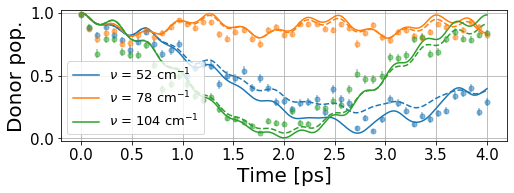

In [34]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
i = 0
n_steps = np.linspace(0, steps, steps+1)*12/200
n_steps = n_steps * scale
fig, ax = plt.subplots(1, figsize=(8, 2.4))

nu_ls = np.array(df['nu'])*100
for i in [0, 1, 2]:
    filename = df['filename'][i]
    xdata, ydata = readFile(filename)
    xdata = np.array(xdata)*12/200 
    xdata = xdata * scale
    ax.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/200),\
                fmt='o', alpha=0.5,markersize=5, color=color_list[i], ecolor=color_list[i],\
                mfc=color_list[i])
    ax.plot(n_steps, pops_list[i], ls = '--', color=color_list[i])
    ax.plot(n_steps, pops_list_coh[i], ls = '-', color=color_list[i], label = r'$\nu$ = %.0f cm$^{-1}$'%nu_ls[i])

ax.set_xlabel(r'Time [ps]')
ax.set_ylabel('Donor pop.')
ax.legend()
ax.grid()
ax.set_ylim([-0.02, 1.02])

fig.savefig('Figure5_1.png', dpi=300, bbox_inches='tight')